# PI-II: Demo QRF

A simple example of fitting a quantile regression forest (QRF) using the [quantile-forest](https://zillow.github.io/quantile-forest/) package to estimate prediction intervals.

Starter script for the [Prediction interval competition II: House price](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price/overview) competition.

這個是 baseline 加上 feature engineering、改用 LGBM

In [1]:
!pip install -q quantile-forest 2>/dev/null  # package for quantile regression forests

In [3]:
import numpy as np
import pandas as pd
from quantile_forest import RandomForestQuantileRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

random_state = 0
np.random.seed(random_state)

# Competition variables.
base_path = "../prediction-interval-competition-ii-house-price/"
alpha = 0.1  # the specified competition alpha (i.e., 90% coverage)

In [4]:
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).
        return_coverage (bool): If True, also return empirical coverage.

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)

In [5]:
df = pd.read_csv(base_path + "dataset.csv", index_col="id", parse_dates=["sale_date"])
df_test = pd.read_csv(base_path + "test.csv", index_col="id", parse_dates=["sale_date"])

## Data Preparation

Prepare the data, including separating features and target, encoding categoricals, imputation, and simple feature engineering.

In [6]:
# Split features and target.
X = df.drop("sale_price", axis=1)
y = df["sale_price"]

# Split train/val and test.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.50, random_state=random_state
)
X_test = df_test.copy()

In [7]:
# Ordinal encoding.
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_val[cat_cols] = encoder.transform(X_val[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [8]:
# Imputation.
num_cols = X_train.select_dtypes(include="number").columns.tolist()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")


def impute(df, cols, imputer, fit=False):
    """Helper function for imputation."""
    if fit:
        return pd.DataFrame(imputer.fit_transform(df[cols]), columns=cols, index=df.index)
    else:
        return pd.DataFrame(imputer.transform(df[cols]), columns=cols, index=df.index)


X_train[num_cols] = impute(X_train, num_cols, num_imputer, fit=True)
X_val[num_cols] = impute(X_val, num_cols, num_imputer)
X_test[num_cols] = impute(X_test, num_cols, num_imputer)

X_train[cat_cols] = impute(X_train, cat_cols, cat_imputer, fit=True)
X_val[cat_cols] = impute(X_val, cat_cols, cat_imputer)
X_test[cat_cols] = impute(X_test, cat_cols, cat_imputer)

In [9]:
class SaleDateEncoder(BaseEstimator, TransformerMixin):
    """Encode sale date as a week of the year feature."""

    def __init__(self, date_column="sale_date"):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.assign(
            **{
                "sale_week": lambda x: x["sale_date"].dt.isocalendar().week,
            }
        )#.drop(columns=["sale_date"])
        return X

    def fit_transform(self, X):
        return self.fit(self, X).transform(X)


# Sale date encoding.
saledate_encoder = SaleDateEncoder(date_column="sale_date")
X_train = saledate_encoder.fit_transform(X_train)
X_val = saledate_encoder.transform(X_val)
X_test = saledate_encoder.transform(X_test)

## Feature Engineering

In [10]:
from sklearn.preprocessing import LabelEncoder

def feat_eng(df):
    df['total_val'] = df['land_val'] + df['imp_val']
    df['land_ratio'] = df['land_val'] / df['total_val']
    #df['improvement_ratio'] = df['imp_val'] / df['total_val']
    #df['land_util_ratio'] = df['sqft'] / df['sqft_lot']

    #df['fbsmt_grade_ratio'] = (df['fbsmt_grade'] / df['grade']).replace([np.inf, -np.inf], np.nan)
    df['total_baths'] = (
        df['bath_full'] +
        0.75 * df['bath_3qtr'] +
        0.5 * df['bath_half']
    )
    df['is_master_suite'] = (df['bath_full'] > df['beds'] * 0.8).astype(int)
    df['has_garage'] = (df['gara_sqft'] > 0).astype(int)
    df['garage_spots'] = (df['gara_sqft'] / 200).round().astype(int).fillna(0)

    # Badmos Billa's feat.eng.
    # https://www.kaggle.com/code/dhritimanchakrabarty/catboost-xgboost-and-lightgbm-along-with-eda
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['age'] = df['sale_year'] - df['year_built']
    df['living_area'] = df['sqft'] + df['sqft_fbsmt']
    for col in ['sale_warning', 'join_status', 'city', 'zoning']:
         df[col] = df[col].astype(str)
         df[col] = LabelEncoder().fit_transform(df[col])
    
    return df.drop(columns=['sale_date', 'golf', 'view_rainier', 'view_skyline', 'view_lakesamm', 'view_otherwater', 'view_other'])

In [11]:
X_train2 = feat_eng(X_train)
X_val2 = feat_eng(X_val)
X_test2 = feat_eng(X_test)

## Model Fitting

Fit a QRF model and use it to estimate a nominal marginal coverage of 90% (quantiles 0.05 and 0.95).

In [12]:
import lightgbm as lgb

quantiles = [alpha / 2, 1 - alpha / 2]
lgb_lower = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.05,
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_upper = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.95,
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_lower.fit(X_train2, y_train)
lgb_upper.fit(X_train2, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4462
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 49
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4462
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 49
[LightGBM] [Info] Start training from score 1425000.000000


LGBMRegressor(alpha=0.95, colsample_bytree=0.8, learning_rate=0.05,
              n_estimators=1200, num_leaves=63, objective='quantile',
              random_state=42, subsample=0.8)

In [13]:
val_lower_lgb = lgb_lower.predict(X_val2)
val_upper_lgb = lgb_upper.predict(X_val2)

## Evaluation

Evaluate the QRF predictions on the validation data.

In [14]:
lgb_score, coverage = winkler_score(
    y_val, 
    val_lower_lgb, 
    val_upper_lgb,
    alpha=alpha,
    return_coverage=True,)
print("The results of lightgbm is this ")

print("Mean Winkler Score:", round(lgb_score, 2))
print("Coverage:", round(coverage * 100, 1), "%")

The results of lightgbm is this 
Mean Winkler Score: 370639.33
Coverage: 86.7 %


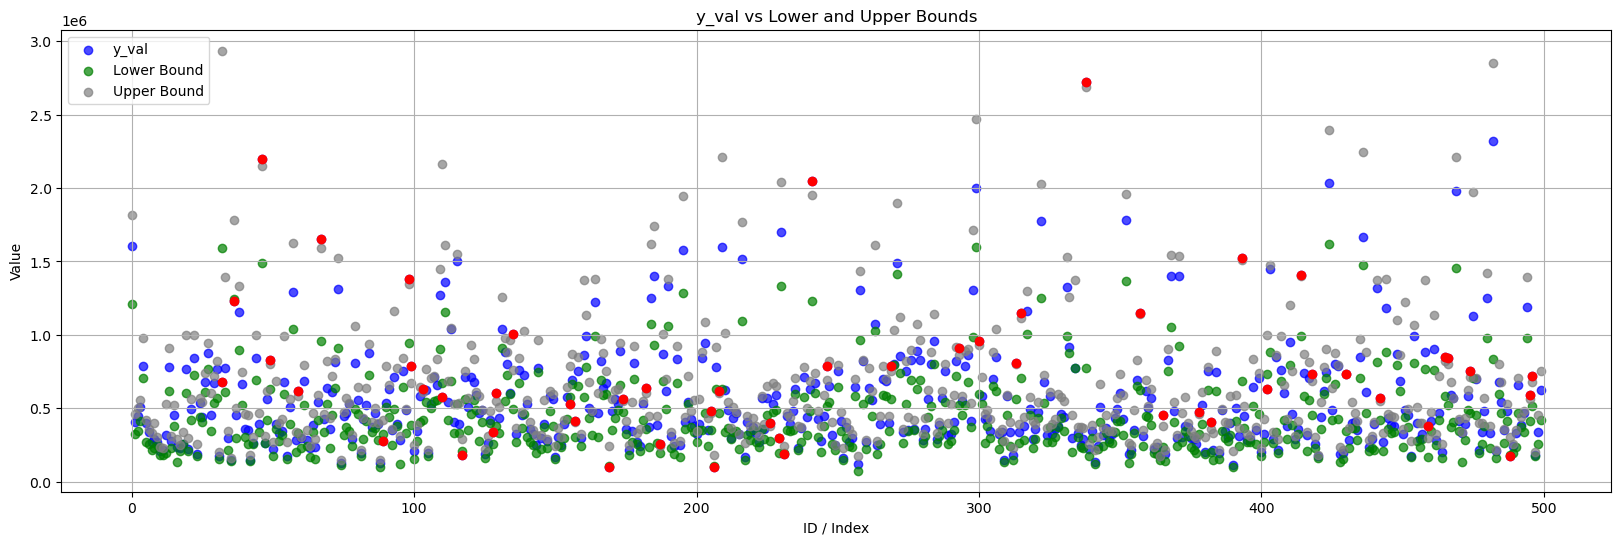

In [24]:
import matplotlib.pyplot as plt


def draw(y_val, val_lower_lgb, val_upper_lgb):
    # 使用 y_val 的 index 作為 x 軸
    x = list(range(len(y_val)))
    
    is_within_bounds = [(lower <= y <= upper) for y, lower, upper in zip(y_val, val_lower_lgb, val_upper_lgb)]
    
    plt.figure(figsize=(20, 6))

    plt.scatter(x, y_val, label='y_val', color='blue', marker='o', alpha=0.7)
    plt.scatter(x, val_lower_lgb, label='Lower Bound', marker='o', color='green', alpha=0.7)
    plt.scatter(x, val_upper_lgb, label='Upper Bound', marker='o', color='grey', alpha=0.7)

    for i, within in enumerate(is_within_bounds):
        if not within:
            plt.scatter(x[i], y_val.iloc[i] if hasattr(y_val, 'iloc') else y_val[i], 
                        color='red', label='Out of Bounds' if i == 0 else "", zorder=5)

    plt.title('y_val vs Lower and Upper Bounds')
    plt.xlabel('ID / Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.show()

y_val_sm = y_val[:500]
val_lower_lgb_sm = val_lower_lgb[:500]
val_upper_lgb_sm = val_upper_lgb[:500]

draw(y_val_sm, val_lower_lgb_sm, val_upper_lgb_sm)


## Submission

In [101]:
# Predict intervals on test set.
test_preds_lower = lgb_lower.predict(X_test2)
test_preds_upper = lgb_upper.predict(X_test2)

sample_submission = pd.read_csv(base_path + "sample_submission.csv")
sample_submission["pi_lower"] = test_preds_lower
sample_submission["pi_upper"] = test_preds_upper
sample_submission.to_csv("submission.csv", index=False)
W
sample_submission

,id,pi_lower,pi_upper
0,200000,819593.333334,1.080562e+06
1,200001,559720.983506,7.649037e+05
2,200002,426916.269811,6.439430e+05
3,200003,298325.232190,4.079507e+05
4,200004,402285.111350,6.626079e+05
...,...,...,...
199995,399995,231036.525908,3.548463e+05
199996,399996,251219.480051,3.479081e+05
199997,399997,378083.105717,4.960733e+05
199998,399998,455865.092508,5.486830e+05
